# Time Series Anomaly Detection with aeon

The aim of Time Series Anomaly Detection is to discover regions of a time series that, in some way, are not representative of the underlying generative process. An anomaly in a time series can be a single point or a subsequence that deviates from the regular patterns of the sequence with respect to some measure, model or embedding. This notebook gives an overview of the anomaly detection module and the available detectors.[1]

<img src="img/anomaly_detection.png" width="600" alt="time series anomalies">

## Data Storage and Problem types

The anomaly detectors in the `aeon.anomaly_detection` module are designed with diverse capabilities. They are categorized based on their input data format, output format, and learning type.

### Input data format
The anomaly detectors in aeon accept time series input in either `np.ndarray` or `pd.DataFrame` formats. The shape of the input can vary depending on the number of time points (`m`) and the number of channels (`d`).

**Univariate series (default):**
* Numpy Array: shape `(m,)`, `(m, 1)` or `(1, m)` depending on the axis.
* Pandas DataFrame: shape `(m, 1)` or `(1, m)` depending on the axis.
* Pandas Series: shape `(m,)`.

Example: `MERLIN`.

**Multivariate series:**

* Numpy Array: shape `(m, d)` or `(d, m)` depending on axis.
* Pandas DataFrame: shape `(m, d)` or `(d, m)` depending on axis.

Example: `KMeansAD`.

### Output format
The anomaly detectors would return one of the following as output:

**Anomaly scores (default):**

np.ndarray, shape (m,) of type float. For each point of the input time series, the anomaly score is a float value indicating the degree of anomalousness. The higher the score, the more anomalous the point. The detectors return raw anomaly scores that are not normalized. 

Example: `PyODAdapter`.

**Binary classification:**

np.ndarray, shape (m,) of type bool or int. For each point of the input time series, the output is a boolean or integer value indicating whether the point is anomalous (`True`/`1`) or not (`False`/`0`). 

Example: `STRAY`.

Each detector in the module specifies its supported input data format, output format, and learning type as an overview table in its documentation. Some detectors support multiple learning types as well.

There are a couple of functions in the `aeon.datasets` module to load anomaly detection datasets. Here, we'll load the KDD-TSAD 135 UCR_Anomaly_Internal_Bleeding16 univariate dataset.

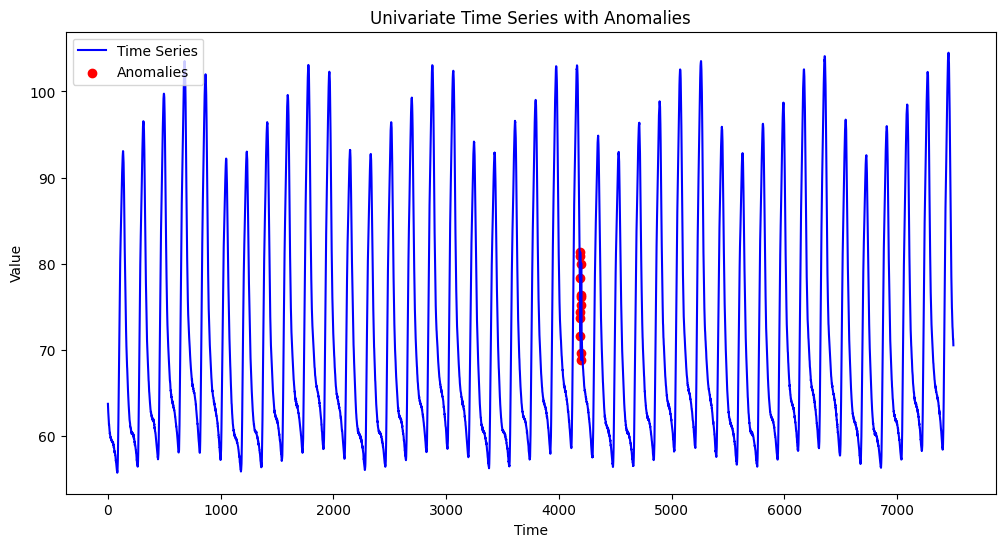

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np

from aeon.datasets import load_kdd_tsad_135

warnings.filterwarnings("ignore")

X, y = load_kdd_tsad_135()

# Create a time axis
time = np.arange(len(X))

# Separate normal and anomaly points
normal_idx = y == 0
anomaly_idx = y == 1

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(time, X, label="Time Series", color="blue", linewidth=1.5)

# Highlight anomalies
plt.scatter(time[anomaly_idx], np.array(X)[anomaly_idx], color="red", label="Anomalies")

plt.title("Univariate Time Series with Anomalies")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

## Anomaly Detection in aeon

All the anomaly detectors inherit from the `BaseAnomalyDetector` class and can be categorized into one of the three categories: 

**Unsupervised (default):**
Unsupervised detectors do not require training data and can be used directly on the target time series. You would usually call the `fit_predict` method on these detectors. 

Example: `DWT_MLEAD`.

**Semi-supervised:**
Semi-supervised detectors require a training step on a time series without anomalies (normal behaving time series). The target value `y` would consist of only zeros. You would usually first call the `fit` method on the training time series and then the `predict` method on your target time series. 

Example: `KMeansAD`.

**Supervised:**
Supervised detectors require a training step on a time series with known anomalies (anomalies should be present and must be annotated). The detector implements the `fit` method, and the target value y consists of zeros and ones, ones indicating points of an anomaly. You would usually first call the `fit` method on the training data and then the `predict` method on your target time series.

We currently don't have any supervised detectors. Still, the problem can be treated as an imbalanced binary classification problem, and time series classifiers can be used from the `aeon.classification` module. 

Following is the list of all the anomaly detectors available in aeon.

In [2]:
from aeon.utils.discovery import all_estimators

detectors = all_estimators("anomaly-detector")
detectors

[('CBLOF', aeon.anomaly_detection._cblof.CBLOF),
 ('COPOD', aeon.anomaly_detection._copod.COPOD),
 ('DWT_MLEAD', aeon.anomaly_detection._dwt_mlead.DWT_MLEAD),
 ('IsolationForest', aeon.anomaly_detection._iforest.IsolationForest),
 ('KMeansAD', aeon.anomaly_detection._kmeans.KMeansAD),
 ('LOF', aeon.anomaly_detection._lof.LOF),
 ('LeftSTAMPi', aeon.anomaly_detection._left_stampi.LeftSTAMPi),
 ('MERLIN', aeon.anomaly_detection._merlin.MERLIN),
 ('OneClassSVM', aeon.anomaly_detection._one_class_svm.OneClassSVM),
 ('PyODAdapter', aeon.anomaly_detection._pyodadapter.PyODAdapter),
 ('STOMP', aeon.anomaly_detection._stomp.STOMP),
 ('STRAY', aeon.anomaly_detection._stray.STRAY)]

For example, we have STOMP, which computes the matrix profile and records the distance of each subsequence (of a specific size) to its nearest non-self neighbour. The matrix profile can directly be interpreted as an anomaly score because a considerable distance to the closest neighbour might indicate an anomalous subsequence. We have various performance metrics such as `range_roc_auc_score` to assess the detectors.

In [ ]:
from aeon.anomaly_detection import STOMP
from aeon.benchmarking.metrics.anomaly_detection import range_roc_auc_score

detector = STOMP(window_size=200)
scores = detector.fit_predict(X)
y_pred = detector.fit_predict(X)
range_roc_auc_score(y, y_pred)

Another example is the `PyODAdapter`, which allows us to use all outlier detection methods of [PyOD](https://pyod.readthedocs.io/en/latest/) for time series anomaly detection.

In [ ]:
from pyod.models.ocsvm import OCSVM

from aeon.anomaly_detection import PyODAdapter
from aeon.benchmarking.metrics.anomaly_detection import range_roc_auc_score

detector = PyODAdapter(OCSVM(), window_size=3)
y_scores = detector.fit_predict(X, axis=0)
range_roc_auc_score(y, y_scores)

## References

[1] Sebastian Schmidl, Phillip Wenig, and Thorsten Papenbrock. Anomaly
 Detection in Time Series: A Comprehensive Evaluation. PVLDB, 15(9): 1779- 1797, 2022.
 doi:10.14778/3538598.3538602